In [1]:
# %load_ext autoreload
# %autoreload 2
from paper import *
from animation import DynamicsAnimation
from tqdm import tqdm
from lmfit import minimize, Parameters

In [2]:
def power_law(x, gamma, a):
    return a * x ** -gamma

def residual(params, x, data, uncertainty):
    gamma = params["gamma"]
    a = params["a"]
    model = power_law(x, gamma, a)
    return (data - model) / uncertainty

In [3]:
M0 = 4
levels = 8
alpha = 2.5

# links = get_HMN(M0, levels, alpha)
# np.save("data/links", links)
# links = np.load("data/links.npy")
# print(f"The network has {len(links)} nodes.")
# plot_HMN(links)

In [4]:
def determine_kappa(num_rep, T, precision, kappa_min, kappa_max, start=200):
    while kappa_max - kappa_min > precision:
        kappa = 0.5 * (kappa_min + kappa_max)
        print(f"Trying out kappa = {kappa}")
        initials = np.random.randint(0, 2, (num_rep, len(links)), dtype=np.uint8)
        density = np.zeros(T+1)
        for i in tqdm(range(num_rep)):
            # print(".", end="")
            data = run_dynamics(links, initials[i], T, kappa)
            density += np.mean(data, axis=1)
        density /= num_rep

        params = Parameters()
        params.add("gamma", value=1.0, min=0.0)
        params.add("a", value=1.0, min=0.0, max=1.0)
        # params.add("b", value=0.0, min=0.0, max=1.0)
        out = minimize(residual, params,args=(np.arange(T+1)[start:], density[start:], np.ones(T+1-start)))
        gamma_opt = out.params["gamma"].value
        a_opt = out.params["a"].value
        # b_opt = out.params["b"].value
        density_fitted = power_law(np.arange(T+1)[start:], gamma_opt, a_opt)#, b_opt)
        plt.title(f"gamma = {gamma_opt}")
        plt.plot(density, label="data")
        plt.plot(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(density, label="data")
        plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        flag = input("Next step: go down [d] or up [u]? ")
        if "d" in flag:
            kappa_max = kappa
        elif "u" in flag:
            kappa_min = kappa
        elif "q" in flag:
            print("Quitting instantly...")
            return 0
        else:
            print("Invalid input, ending now...")
            break
    print(" ")
    print(f"kappa_min: {kappa_min}")
    data = run_dynamics(links, initials[i], T, kappa_min)
    plot_dynamics(data)
    print(f"kappa: {kappa}")
    data = run_dynamics(links, initials[i], T, kappa)
    plot_dynamics(data)
    print(f"kappa_max: {kappa_max}")
    data = run_dynamics(links, initials[i], T, kappa_max)
    plot_dynamics(data)

In [5]:
def determine_kappa_auto(num_rep, T, num_trials, kappa_min, kappa_max, start=200, HMN_per_rep=False):
    for kappa in np.linspace(kappa_min, kappa_max, num_trials):
        links = get_HMN(M0, levels, alpha)
        print(f"Trying out kappa = {kappa}")
        # Running experiment
        initials = np.random.randint(0, 2, (num_rep, len(links)), dtype=np.uint8)
        density = np.zeros(T+1)
        for i in tqdm(range(num_rep)):
            # print(".", end="")
            if HMN_per_rep:
                links = get_HMN(M0, levels, alpha)
            data = run_dynamics(links, initials[i], T, kappa)
            density += np.mean(data, axis=1)
        density /= num_rep

        # Fitting data
        params = Parameters()
        params.add("gamma", value=1.0, min=0.0)
        params.add("a", value=1.0, min=0.0, max=1.0)
        # params.add("b", value=0.0, min=0.0, max=1.0)
        out = minimize(residual, params,args=(np.arange(T+1)[start:], density[start:], np.ones(T+1-start)))
        gamma_opt = out.params["gamma"].value
        a_opt = out.params["a"].value
        # b_opt = out.params["b"].value
        density_fitted = power_law(np.arange(T+1)[start:], gamma_opt, a_opt)#, b_opt)

        # Plotting results
        plt.title(f"gamma = {gamma_opt}")
        plt.plot(density, label="data")
        # plt.plot(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(density, label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(np.arange(T+1)[start:], density[start:], label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()

In [6]:
def determine_kappa_auto_MC(num_rep, T, num_trials, kappa_min, kappa_max, M0, levels, alpha, start=200, HMN_per_rep=False, HMN_per_kappa=False):
    links = get_HMN(M0, levels, alpha)
    initial = np.ones(len(links))
    density = np.zeros(T+1)
    for kappa in np.linspace(kappa_min, kappa_max, num_trials):
        if HMN_per_kappa:
            links = get_HMN(M0, levels, alpha)
        print(f"Trying out kappa = {kappa}")
        # Running experiment
        # initials = np.random.randint(0, 2, (num_rep, len(links)), dtype=np.uint8)
        for i in tqdm(range(num_rep)):
            # print(".", end="")
            if HMN_per_rep:
                links = get_HMN(M0, levels, alpha)
            data = run_dynamics_MC(links, initial, T, kappa)
            density += np.mean(data, axis=1)
        density /= num_rep

        # Fitting data
        params = Parameters()
        params.add("gamma", value=1.0, min=0.0)
        params.add("a", value=1.0, min=0.0, max=1.0)
        # params.add("b", value=0.0, min=0.0, max=1.0)
        out = minimize(residual, params,args=(np.arange(T+1)[start:], density[start:], np.ones(T+1-start)))
        gamma_opt = out.params["gamma"].value
        a_opt = out.params["a"].value
        # b_opt = out.params["b"].value
        density_fitted = power_law(np.arange(T+1)[start:], gamma_opt, a_opt)#, b_opt)

        # Plotting results
        plt.title(f"gamma = {gamma_opt}")
        plt.plot(density, label="data")
        # plt.plot(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(density, label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(np.arange(T+1)[start:], density[start:], label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()

In [7]:
def determine_kappa_manual_MC(num_rep, T, kappa, M0, levels, alpha, start=200, HMN_per_rep=False,):
    links = get_HMN(M0, levels, alpha)
    initial = np.ones(len(links))
    density = np.zeros(T+1)
    print(f"Trying out kappa = {kappa}")
    
    # Running experiment
    for i in tqdm(range(num_rep)):
        # print(".", end="")
        if HMN_per_rep:
            links = get_HMN(M0, levels, alpha)
        density += run_dynamics_MC_sparse(links, initial, T, kappa)
    density /= num_rep

    # Plotting results
    plt.title(f"kappa = {kappa}")
    plt.plot(density, label="data")
    plt.show()
    plt.title(f"kappa = {kappa}")
    plt.loglog(density, label="data")
    plt.show()
    plt.title(f"kappa = {kappa}")
    plt.loglog(np.arange(T+1)[start:], density[start:], label="data")
    plt.show()

Kappa: 0.5
Trying out kappa = 0.5


100%|██████████| 1000/1000 [00:42<00:00, 23.79it/s]


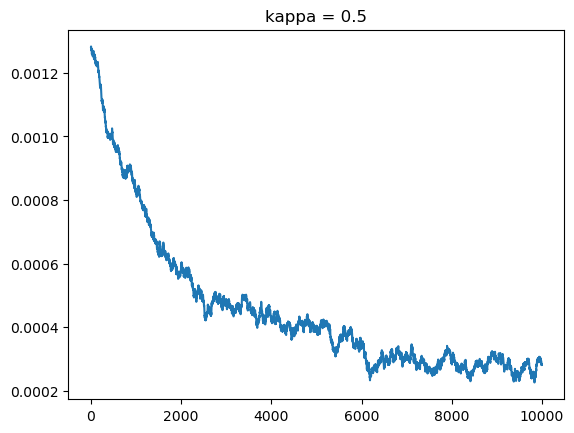

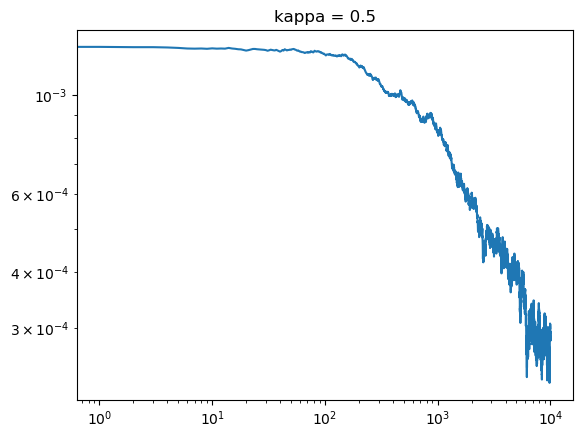

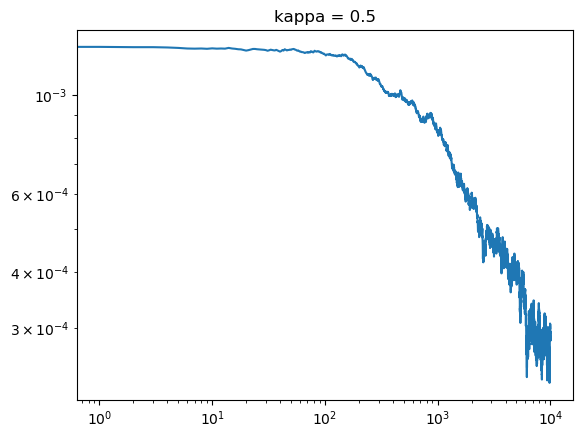

Increasing time
Kappa: 0.5
Trying out kappa = 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

: 

: 

In [9]:
M0 = 4
levels = 8
alpha = 2.5

num_rep = 1000
T = 10000

kappa_min = 0.4
kappa_max = 0.6

while True:
    kappa = 0.5 * (kappa_min + kappa_max)
    # optionals = [0.1, 1]  # dt, mu for continuous, None for discrete
    # anim = DynamicsAnimation(run_dynamics_cont, links, initial, kappa, T, optionals)
    print(f"Kappa: {kappa}")
    determine_kappa_manual_MC(num_rep, T, kappa, M0, levels, alpha, start=0)
    flag = input("Next step: go down [d] or up [u] or repeat same [enter] or quit [q]? ")
    if "d" in flag:
        kappa_max = kappa
    elif "u" in flag:
        kappa_min = kappa
    elif "q" in flag:
        print("Quitting instantly...")
        break
    elif "tp" in flag:
        print("Increasing time")
        T *= 10
    elif "tm" in flag:
        print("Decreasing time")
        T /= 10
    else:
        print("Repeating same...")
print(f"kappa_min: {kappa_min}")
print(f"kappa: {kappa}")
print(f"kappa_max: {kappa_max}")